![download.png](download.png)


## Import Packages

In [1]:
#Import Python packages
import pandas as pd
import plotly.express as px
import json
import sys
import cachetools
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import json
import datetime

# for splitting of the dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder

#ML-Models: Classification
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn. ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import AdaBoostClassifier
from sklearn.svm import SVC


# for getting metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# model selection
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

## Connect to Snowflake

In [2]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## Gathering Data as Snowpark DataFrame

In [3]:
#Orders_V
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
#Customer Loyalty
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

## Data Exploration 
*To choose which country to work on*

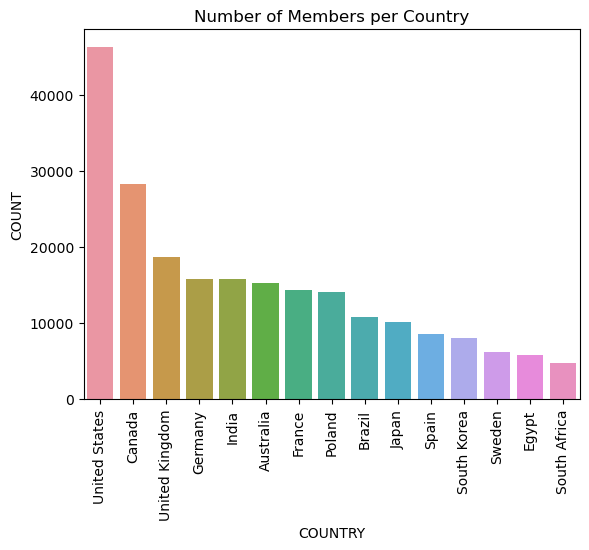

In [4]:
#Unique members
temp_df=tasty_bytes_customer_loyalty.group_by(F.col('Country')).count().to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=temp_df)
plt.xticks(rotation=90)
plt.title('Number of Members per Country')
plt.show()

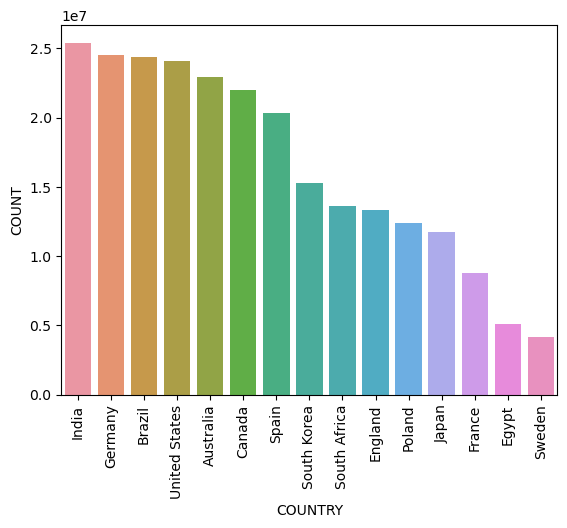

In [5]:
#Number of unique transactions
temp_df=tasty_bytes_orders_v.group_by(F.col('COUNTRY')).agg(F.countDistinct('ORDER_ID').alias('COUNT')).to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=temp_df)
plt.xticks(rotation=90)
plt.title('')
plt.show()

In [6]:
#Get last transaction date for each country
last_tran_country = tasty_bytes_orders_v.group_by(F.col('COUNTRY')).max(F.to_date(F.col('ORDER_TS'))).to_pandas()

#Get assumed churned date which is two weeks before last transaction date, then get total number of customers in the assumed time period
last_tran_country['CHURN_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=14)
last_tran_country['CUSTOMER_COUNT_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=44)

#Make pandas dataframe into a snowpark dataframe
last_tran_country_sdf=session.createDataFrame(last_tran_country)

#Merge 
last_tran_country_sdf_join = last_tran_country_sdf.join(
    right=tasty_bytes_orders_v,
    on="COUNTRY",
    how="inner"
)


#Filter dataframe to the assumed time period
df = last_tran_country_sdf_join[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CUSTOMER_COUNT_DATE"]]
df.show()

#Filter to get churned members dataset
df2 = df[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CHURN_DATE"]]

#Number of customers before churn date
cust_bef = df.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_BEF'))
#Number of customers after churn date
cust_aft = df2.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_AFT'))

#Merge
calculator = cust_aft.join(
    right=cust_bef,
    on="COUNTRY",
    how="inner"
)
calc = calculator.to_pandas()

#Calculate Churn rate 
calc["CHURN_RATE"] = (((calc["COUNT_BEF"] - calc["COUNT_AFT"]) / calc["COUNT_BEF"]) * 100)
temp_df=calc.sort_values(by='CHURN_RATE',ascending=False)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"COUNTRY"  |"MAX(TO_DATE(ORDER_TS))"  |"CHURN_DATE"  |"CUSTOMER_COUNT_DATE"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"   |"PRI

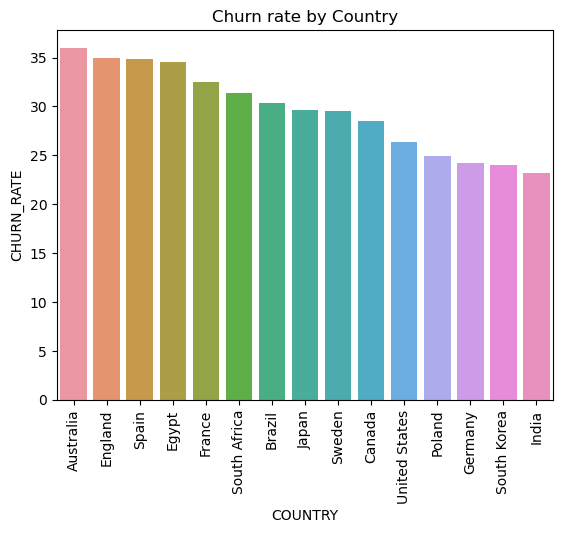

In [7]:
#Churn rate by Country
sns.barplot(x='COUNTRY',y='CHURN_RATE',data=temp_df)
plt.xticks(rotation=90)
plt.title('Churn rate by Country')
plt.show()

We decided to work on United States as it has the most number of customers, a high number of customers and quite a high Churn Rate.

## Preparing the table for Modelling

In [8]:
#Filter to only Australia
filtered_country_customer_df=tasty_bytes_customer_loyalty.filter(F.col('COUNTRY')=='United States')

#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=filtered_country_customer_df,
    on="CUSTOMER_ID",
    how="inner"
)
loyal_customer_orders.show()
print('Number of rows:',loyal_customer_orders.count())

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

In [10]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)
loyal_customer_orders.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"  |

In [11]:
#Total Quantity of each order
temp_df=loyal_customer_orders.group_by(F.col('ORDER_ID')).agg(F.sum(F.col('QUANTITY')).alias('Total_Quantity'))

#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])

#Merge to get transactions table
combined_df=remove_dup.join(
    right=temp_df,
    on="ORDER_ID",
    how="inner"
)
combined_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"CUSTOMER_ID"  |"DATE"      |"TRUCK_ID"  |"ORDER_TS"           

In [12]:
# assuming you have a DataFrame called `orders` with columns `customer_id` and `order_ts`
window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').desc())

orders_with_rank = combined_df.withColumn('rank', F.rank().over(window_spec))

#Get max order of each customer
max_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')

#Get second max order of each customer
second_max_order_ts = orders_with_rank.filter(F.col('rank') == 2).select('customer_id', 'order_ts')


In [13]:
#Rename columns
second_max_order_ts = second_max_order_ts.withColumnRenamed('ORDER_TS','2ndMax_Order_TS')
max_order_ts = max_order_ts.withColumnRenamed('ORDER_TS','Max_Order_TS')

In [14]:
#Merge with secon max order dataframe
temp_df=combined_df.join(right=second_max_order_ts,on='CUSTOMER_ID',how='inner')

#Filter out last purchase
filtered_df = temp_df.filter(F.col('ORDER_TS') <= F.col('2ndMax_Order_TS'))

### Feature Engineering: Adding RFM Columns

In [15]:
#Display last purchase
tasty_bytes_orders_v.select(F.max('ORDER_TS')).show()

-----------------------
|"MAX(""ORDER_TS"")"  |
-----------------------
|2022-11-01 22:59:59  |
-----------------------



In [16]:
#Get last purchase date as a variable
lastdate=tasty_bytes_orders_v.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = filtered_df.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = filtered_df.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = filtered_df.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')

### Feature Engineering: Adding Average Time Difference, Max and Min Days without Purchase

In [17]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the prior order for each customer and menu item
orders_df = filtered_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.lag("DATE").over(window_spec))

# Calculate the number of days between the prior order and the current order for each customer and menu item
orders_df = orders_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.datediff(col1="DAYS_SINCE_PRIOR_ORDER", col2="DATE",part='day'))
orders_df = orders_df.na.drop(subset=["DAYS_SINCE_PRIOR_ORDER"])

#Calculate the average purchase time difference for each customer
avg_time_diff=orders_df.group_by('CUSTOMER_ID').agg(F.round(F.avg('DAYS_SINCE_PRIOR_ORDER'),0).alias('Avg_Days_Between_Purchase'))

# Max Days without Purchase
max_days=orders_df.group_by('CUSTOMER_ID').agg(F.max('DAYS_SINCE_PRIOR_ORDER').alias('Max_Days_Without_Purchase'))

# Min Days without Purchase
min_days=orders_df.group_by('CUSTOMER_ID').agg(F.min('DAYS_SINCE_PRIOR_ORDER').alias('Min_Days_Without_Purchase'))

### Feature Engineering Categorical Variables

In [18]:
#Get Customer demographic
cust_demo=filtered_country_customer_df.select('CUSTOMER_ID','BIRTHDAY_DATE','GENDER','MARITAL_STATUS')

# get AGE variable
cust_demo = cust_demo.withColumn("AGE", F.datediff('year', F.col("BIRTHDAY_DATE"),F.lit(lastdate)))

cust_demo.show()


------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"BIRTHDAY_DATE"  |"GENDER"     |"MARITAL_STATUS"    |"AGE"  |
------------------------------------------------------------------------------
|118            |1988-06-13       |Male         |Single              |34     |
|189            |1984-03-05       |Undisclosed  |Married             |38     |
|204            |1979-06-25       |Male         |Undisclosed         |43     |
|42             |1966-06-28       |Undisclosed  |Single              |56     |
|59             |1961-06-05       |Male         |Married             |61     |
|65             |1958-09-01       |Male         |Divorced/Seperated  |64     |
|106            |1967-05-10       |Female       |Single              |55     |
|219            |1965-12-19       |Undisclosed  |Married             |57     |
|222            |1965-07-06       |Female       |Single              |57     |
|22             |1949-01-12       |Male         |Mar

In [31]:
#Merge to get final dataframe
final_df = RFM_table.join(max_order_ts, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(avg_time_diff, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(max_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(min_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(cust_demo,on='CUSTOMER_ID',how='inner')

#Convert to pandas
final_df=final_df.to_pandas()

In [32]:
#Add Days To Next Order
final_df['Days_To_Next_Order']=(final_df['MAX_ORDER_TS']-final_df['ORDER_TS']).dt.days

In [20]:
# # get categorical data
# cat_df = temp_df.copy()
# cat_df = cat_df.drop(columns=['ORDER_ID','POSTAL_CODE','PREFERRED_LANGUAGE','SIGN_UP_DATE',
#                      'DATE','TRUCK_ID','ORDER_TS','ORDER_DETAIL_ID', 'LINE_NUMBER',
#                      'TRUCK_BRAND_NAME', 'MENU_TYPE', 'PRIMARY_CITY', 'REGION', 'COUNTRY',
#                      'FRANCHISE_FLAG', 'FRANCHISE_ID', 'FRANCHISEE_FIRST_NAME', 'FRANCHISEE_LAST_NAME',
#                      'LOCATION_ID','FRANCHISEE_FIRST_NAME','FRANCHISEE_LAST_NAME','LOCATION_ID','PLACEKEY',
#                      'LOCATION_NAME','TOP_CATEGORY','SUB_CATEGORY','LATITUDE','LONGITUDE','FIRST_NAME',
#                      'LAST_NAME','E_MAIL','PHONE_NUMBER','CHILDREN_COUNT','MENU_ITEM_ID','MENU_ITEM_NAME',
#                      'QUANTITY','UNIT_PRICE','PRICE','ORDER_AMOUNT','ORDER_TAX_AMOUNT',
#                      'ORDER_DISCOUNT_AMOUNT', 'ORDER_TOTAL','TOTAL_QUANTITY','2ndMax_Order_TS','CITY','time_diff'])

# final_df = final_df.merge(right=cat_df,how='left',on='CUSTOMER_ID')

# # get max date/latest date in the ORDER_TS column
# latest_date = pd.Timestamp('2022-11-01 00:00:00')

# final_df["BIRTHDAY_DATE"] = final_df["BIRTHDAY_DATE"].apply(pd.to_datetime)

# final_df["AGE"] = ((latest_date - final_df["BIRTHDAY_DATE"])/np.timedelta64(1,'Y'))

# final_df["AGE"] = final_df["AGE"].round()
# final_df['FAVOURITE_BRAND'] = final_df['FAVOURITE_BRAND'].fillna("Undisclosed")
# final_df['GENDER'] = final_df['GENDER'].fillna("Undisclosed")
# final_df['MARITAL_STATUS'] = final_df['MARITAL_STATUS'].fillna("Undisclosed")

# final_df["FAVOURITE_BRAND"] = final_df["FAVOURITE_BRAND"].astype('category')
# final_df["GENDER"] = final_df["GENDER"].astype('category')
# final_df["MARITAL_STATUS"] = final_df["MARITAL_STATUS"].astype('category')

# final_df["FAVOURITE_BRAND_encode"] = final_df["FAVOURITE_BRAND"].cat.codes
# final_df["GENDER_encode"] = final_df["GENDER"].cat.codes
# final_df["MARITAL_STATUS_encode"] = final_df["MARITAL_STATUS"].cat.codes

# from feature_engine.encoding import OneHotEncoder

# ohe_enc = OneHotEncoder(
#     top_categories=None,
#     drop_last=True)  # to return k-1, false to return k

# ohe_enc.fit(final_df)

# final_df = ohe_enc.transform(final_df)

### Outlier Handling

In [38]:
num_cols=final_df.select_dtypes(exclude=['object','datetime64[ns]']).columns.drop('CUSTOMER_ID')

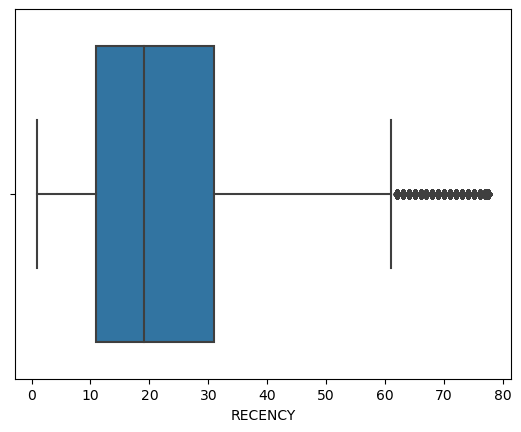

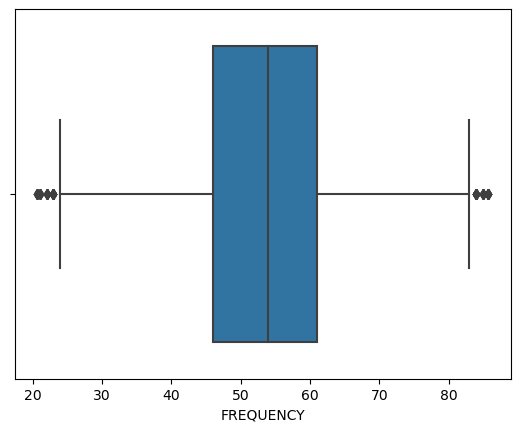

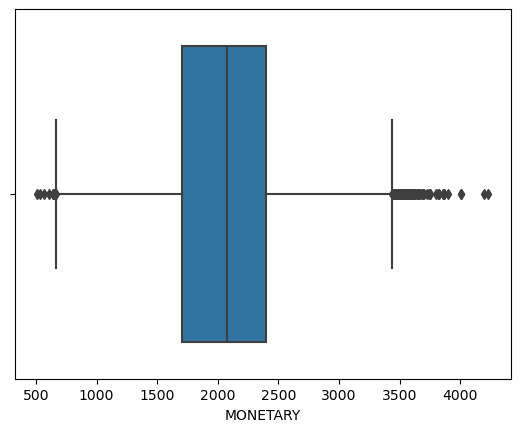

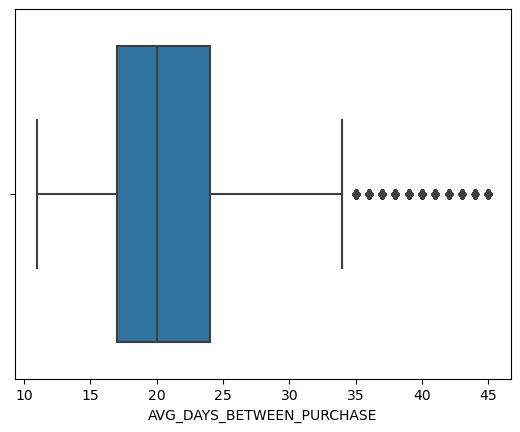

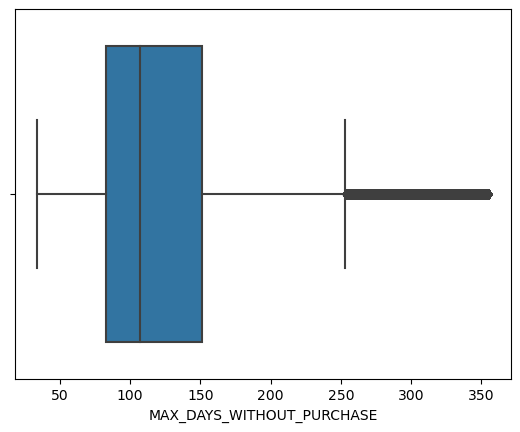

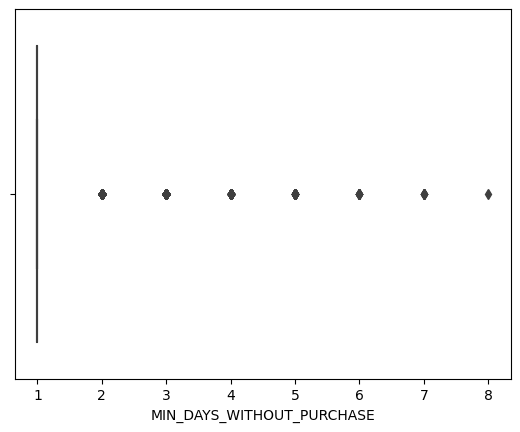

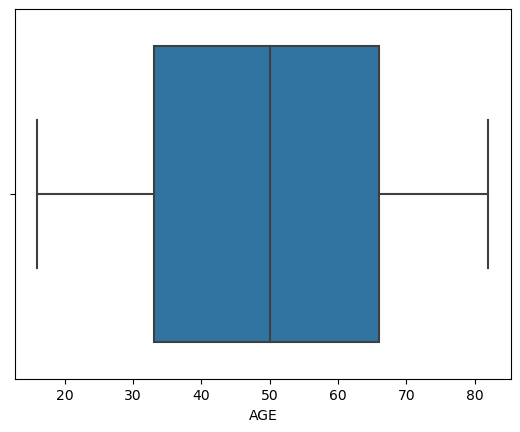

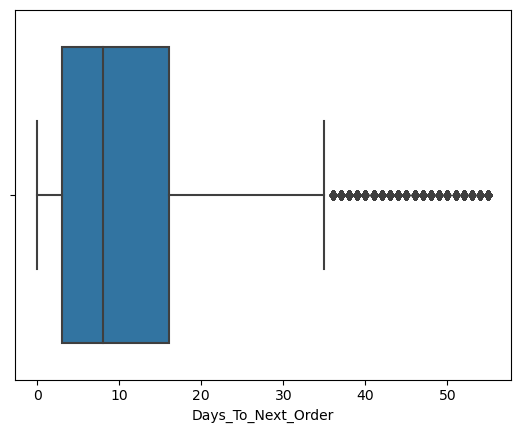

In [62]:
for i in num_cols:
    sns.boxplot(data=final_df,x=final_df_win[i])
    plt.show()

In [54]:
from feature_engine.outliers import Winsorizer
# create the capper
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RECENCY','AVG_DAYS_BETWEEN_PURCHASE','MAX_DAYS_WITHOUT_PURCHASE'])

windsorizer.fit(final_df)


Winsorizer(capping_method='iqr', tail='both',
           variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                      'MAX_DAYS_WITHOUT_PURCHASE', 'Days_To_Next_Order'])

*Note there is no point dealing with outliers in Days to next order as even when dealt with the 50% mark stays the same, meaning no change to our target variable.

In [55]:
final_df_win = windsorizer.transform(final_df)

In [56]:
# create the capper
windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['FREQUENCY','RECENCY'])

windsorizer.fit(final_df_win)

Winsorizer(tail='both', variables=['FREQUENCY', 'RECENCY'])

In [57]:
final_df_win = windsorizer.transform(final_df_win)


### Final Table

In [68]:
#Describe the target
final_df_enc['Days_To_Next_Order'].describe()

count    46300.00000
mean        11.88378
std         11.98193
min          0.00000
25%          3.00000
50%          8.00000
75%         16.00000
max         55.00000
Name: Days_To_Next_Order, dtype: float64

In [69]:
final_df=final_df_enc

In [70]:
#Add Target Variable Next Purchase Day Range 
final_df['NextPurchaseDayRange'] = 1
final_df.loc[final_df['Days_To_Next_Order']<=8,'NextPurchaseDayRange'] = 0

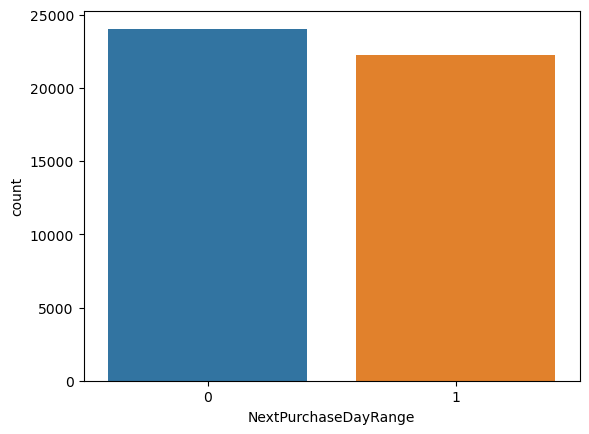

In [71]:
#Distribution of target variable
sns.countplot(data=final_df,x='NextPurchaseDayRange')
plt.show()

In [72]:
# Define Model Inputs (X) and Output (y)
X = final_df.drop(['Days_To_Next_Order','NextPurchaseDayRange','MAX_ORDER_TS','ORDER_TS','FAVOURITE_BRAND_encode','GENDER_encode','MARITAL_STATUS_encode','BIRTHDAY_DATE'], axis =1,
                  errors='ignore')
y = final_df["NextPurchaseDayRange"]

# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

### Categorical Encoding

In [ ]:
#One Hot Encoding
ohe_enc = OneHotEncoder(
    top_categories=None,
    drop_last=True)  # to return k-1, false to return k

ohe_enc.fit(X_train)
X_train_enc = ohe_enc.transform(X_train)
X_test_enc=ohe_enc.transform(X_test)

### Feature Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train_enc)

#transform train and test sets
X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_enc.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_enc.columns)

## Model Building

## Define Evaluation Function

In [73]:
#Function to show MSE, MAE, r-sq of Classification models
def evaluateModel(model):
    #Accuracy
    print('Train Accuracy:',model.score(X_train, y_train),
          '\nTest Accuracy:',model.score(X_test, y_test))

In [74]:
#Function to show MSE, MAE, r-sq of Classification models
def evaluateModelWithName(model,model_name):
    print(model_name)
    print('Train Accuracy:',model.score(X_train, y_train),
          '\nTest Accuracy:',model.score(X_test, y_test),
          '\n')

## Models

### Logistic Regression

#### Build the model

In [75]:
#Build Logistic Regression Model
log_ref_before = LogisticRegression(max_iter=10000)
log_ref_before.fit(X_train, y_train)

evaluateModel(log_ref_before)

Train Accuracy: 0.7497068805924098 
Test Accuracy: 0.7394528437724982


In [ ]:
#Before outlier handling
#Train Accuracy: 0.7485035482875656 
#Test Accuracy: 0.7405327573794096

#### Improve the model

In [28]:
# Task 1: Use GridSearch to find the best combination of model hyperparameters

logreg = LogisticRegression()
param_grid = {"penalty": ["l1", "l2"],
                "C" : [0.1, 1, 10],
                "solver" : ["newton-cg", "lbfgs", "liblinear"]}

gs =GridSearchCV(logreg, param_grid = param_grid, scoring = "accuracy", cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

c:\Users\ryanl\anaconda3\envs\py38_env\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryanl\anaconda3\envs\py38_env\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryanl\anaconda3\envs\py38_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\ryanl\anaconda3\envs\py38_env\lib\site-packages\sklearn\linear_model\_logistic.p

0.7499056213779097
{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [29]:
#Build Logistic Regression Model
log_ref_improved = LogisticRegression(**gs.best_params_)
log_ref_improved.fit(X_train, y_train)

evaluateModel(log_ref_improved)

Train Accuracy: 0.7497200503126564 
Test Accuracy: 0.7486211767762329


## Decision Tree

#### Build the model

In [76]:
#Build Decision Tree Model
decision_tree_before = tree.DecisionTreeClassifier(max_depth = 20)

decision_tree_before.fit(X_train, y_train)

evaluateModel(decision_tree_before)

Train Accuracy: 0.9158284480098735 
Test Accuracy: 0.7070554355651548


#### Improve the model

In [31]:
dt = tree.DecisionTreeClassifier(max_depth = 2)

param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10,20,30,40,50,100], 
              "min_samples_split" : [2, 4, 10, 12, 16], 
              'max_depth' : [2,3,4,5,6,7]}

gs = GridSearchCV(dt, param_grid=param_grid, scoring='accuracy', cv= 10, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train) 

print(gs.best_score_)
print(gs.best_params_)

KeyboardInterrupt: 

In [ ]:
# Create Decision Tree using the best hyperparameters
decision_tree_improved = tree.DecisionTreeClassifier(**gs.best_params_)
decision_tree_improved.fit(X_train, y_train)

evaluateModel(decision_tree_improved)

Train Accuracy: 0.7683122493057698 
Test Accuracy: 0.7710583153347732


### MLP

#### Build the model

In [ ]:
#Build MLP model
MLP_before = MLPClassifier(activation ='logistic', hidden_layer_sizes=(10,), max_iter= 2000, solver = 'sgd', random_state=2)

MLP_before.fit(X_train, y_train)

evaluateModel(MLP_before)

Train Accuracy: 0.5173711817340327 
Test Accuracy: 0.5245500359971202


#### Improve the model

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes = (10,), max_iter = 2000, random_state=2)
param_grid = {"activation": ["logistic", "relu"],
             "hidden_layer_sizes" : [(5,), (10,), (20)],
             "max_iter": [200, 2000, 4000],
             "solver" : ["sgd", "adam"]}

gs =GridSearchCV(mlp, param_grid = param_grid, scoring = "accuracy", cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)
''''{'activation': 'relu',
 'hidden_layer_sizes': 20,
 'max_iter': 2000,
 'solver': 'adam'}'''

0.6538105522986732
{'activation': 'relu', 'hidden_layer_sizes': 20, 'max_iter': 200, 'solver': 'adam'}


"'{'activation': 'relu',\n 'hidden_layer_sizes': 20,\n 'max_iter': 2000,\n 'solver': 'adam'}"

In [ ]:
# Create the ann model
MLP_improved = MLPClassifier(**gs.best_params_)
# Fit the model to the training set
MLP_improved.fit(X_train,y_train)

evaluateModel(MLP_improved)

Train Accuracy: 0.5854674483184202 
Test Accuracy: 0.5903527717782577


### Random Forest

#### Build the model

In [82]:
#Build Random Forest Model

random_forest_before= RandomForestClassifier(n_estimators=100)
random_forest_before.fit(X_train, y_train)

evaluateModel(random_forest_before)

Train Accuracy: 0.9999691453255168 
Test Accuracy: 0.7593952483801296


#### Improve the model

In [ ]:
rf = RandomForestClassifier()
param_grid = {'n_estimators': [1, 10, 50, 100],
'max_depth': [2, 4, 6, 8, 10],
'min_samples_split': [2, 5, 10, 15, 20]}

gs = GridSearchCV(rf, param_grid = param_grid, scoring = "accuracy", cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7673248997223079
{'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
#Task 1: Build Random Forest Model and Evaluate both training and testing accuracy
# Build RandomForest Model and Evaluate both training and testing accuracy
random_forest_improved = RandomForestClassifier(**gs.best_params_)
random_forest_improved.fit(X_train,y_train)

evaluateModel(random_forest_improved)

Train Accuracy: 0.773711817340327 
Test Accuracy: 0.7700503959683226


In [81]:
#Build Ada Boost Model
adb_before = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=5,learning_rate=1)
adb_before.fit(X_train, y_train)

evaluateModel(adb_before)

Train Accuracy: 1.0 
Test Accuracy: 0.680849532037437


In [ ]:
adb = AdaBoostClassifier()

param_grid = {
    'estimator': [tree.DecisionTreeClassifier(max_depth=1), tree.DecisionTreeClassifier(max_depth=2)],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

gs = GridSearchCV(adb, param_grid, cv=5, n_jobs=-1)

gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

c:\Users\ryanl\anaconda3\envs\py38_env\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7683122493057698
{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


In [ ]:
#Task 2: Build Ada Boost Model and Evaluate both training and testing accuracy
adb_improved = AdaBoostClassifier(**gs.best_params_)
adb_improved.fit(X_train,y_train)

evaluateModel(adb_improved)

c:\Users\ryanl\anaconda3\envs\py38_env\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train Accuracy: 0.7683122493057698 
Test Accuracy: 0.7710583153347732


In [78]:
#Build XGBoost Model
xgb_before = XGBClassifier(n_estimators = 20, learning_rate = 0.1, eval_metric='logloss',max_depth = 20)
xgb_before.fit(X_train, y_train)

#Evaluate XGBoost Model
evaluateModel(xgb_before)

Train Accuracy: 0.956618327676643 
Test Accuracy: 0.744060475161987


In [79]:
xgb = XGBClassifier()

param_grid = {
    'max_depth': [2, 3, 4], 
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'objective': ['binary:logistic'],
    'n_jobs': [-1]
}

gs = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1)

gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7715519901265042
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'n_jobs': -1, 'objective': 'binary:logistic'}


In [80]:
# Task 3: Build XGBoost Model and Evaluate both training and testing accuracy 
xgb_improved = XGBClassifier(**gs.best_params_)
xgb_improved.fit(X_train,y_train)

evaluateModel(xgb_improved)

Train Accuracy: 0.7734958346189448 
Test Accuracy: 0.765370770338373


### Support Vector Classifier

#### Build the Model

In [ ]:
# # Task 4: Build SVM Model and Evaluate both training and testing accuracy 

# # Build model
# svc_before = SVC(kernel='linear', C=1)
# svc_before.fit(X_train,y_train)

# evaluateModel(svc_before)

#### Improve the Model

# Model Evaulation

In [ ]:
evaluateModelWithName(log_ref_before,'log_ref_before')
evaluateModelWithName(log_ref_improved,'log_ref_improved')

evaluateModelWithName(decision_tree_before,'decision_tree_before')
evaluateModelWithName(decision_tree_improved,'decision_tree_improved')

evaluateModelWithName(MLP_before,'MLP_before')
evaluateModelWithName(MLP_improved,'MLP_improved')

evaluateModelWithName(adb_before,'adb_before')
evaluateModelWithName(adb_improved,'adb_improved')

evaluateModelWithName(log_ref_before,'log_ref_before')
evaluateModelWithName(log_ref_before,'log_ref_before')

evaluateModelWithName(xgb_before,'xgb_before')
evaluateModelWithName(xgb_improved,'xgb_improved')

# evaluateModelWithName(svc_before,'svc_before')
# evaluateModelWithName(svc_improved,'svc_improved')

In [ ]:
xgb_final=xgb_before

# Data evaluation

In [ ]:
#Check top 10 features based on feature importance
ft_weights_xgb_clf = pd.DataFrame(xgb_final.feature_importances_, columns=['is_promoted'], index=X_train.columns)
ft_weights_xgb_clf.sort_values('is_promoted', ascending=False, inplace=True)
ft_weights_xgb_clf.tail(100)

,is_promoted
RECENCY,0.943381
AVG_TIME_DIFF,0.012582
CUSTOMER_ID,0.011237
monetary,0.010758
Max_Days_Without_Purchase,0.010199
frequency,0.007962
Min_Days_Without_Purchase,0.003881


## Reset

In [ ]:
"""# Drop training table
session.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_train").collect()

# Drop testing table
session.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_test").collect()

# Drop training stored procedure
session.sql("DROP PROCEDURE IF EXISTS sproc_train_linreg(varchar, array, varchar, varchar)").collect()

# Drop inference user-defined function
session.sql(
    "DROP FUNCTION IF EXISTS udf_linreg_predict_location_sales(float, float, float, float, float, float, float, float)"
).collect()

# Drop stage
session.sql("DROP STAGE IF EXISTS model_stage").collect()

# Scale down compute
session.sql("ALTER WAREHOUSE tasty_ds_wh SET WAREHOUSE_SIZE = XSMALL").collect()

# Close the session
session.close()"""